# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [2]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


print("Número de documentos:", len(newsgroupsdocs))
#Verificar antes y despues de limpieza de texto
vectorizer_raw = TfidfVectorizer()
terms_raw = vectorizer_raw.fit(newsgroupsdocs).get_feature_names_out()

#Vectorizerize the documents
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',  # También puedes usar una lista personalizada
    token_pattern=r'(?u)\b[a-záéíóúñü]{2,}\b'  # solo letras, mínimo 2 caracteres
)
corpusvect = vectorizer.fit_transform(newsgroupsdocs)
terms = vectorizer.get_feature_names_out()
print("Número de términos después de limpieza:", len(terms))
print("Términos sin limpieza:", len(terms_raw))


# Cada columna representa un término.
# corpusvect > 0 da True (1) donde el término aparece.
df_counts = (corpusvect > 0).sum(axis=0)  # matriz 1xN
df_array = np.asarray(df_counts).flatten()  # convertir a array 1D

# Asignar a variable df (como Serie de Pandas)
df = pd.Series(df_array, index=terms, name="Document Frequency")

print(df.sort_values(ascending=False).head(10))

#Pasar a dataframe
df_tfidf = pd.DataFrame.sparse.from_spmatrix(corpusvect, columns=terms)

print(df_tfidf.head())  # primeras filas

# Similaridad entre todos los documentos del corpus
similarity_matrix = cosine_similarity(corpusvect)



# Supongamos que quieres ver los 5 documentos más similares al documento 0
doc_id = 5
similarities = similarity_matrix[doc_id]

# Ordenar de mayor a menor similitud, ignorando el propio doc (índice 0)
similar_indices = similarities.argsort()[::-1][1:6]
print(f"Documentos más similares al documento {doc_id}: {similar_indices}")
print(f"Similitudes: {similarities[similar_indices]}")


Número de documentos: 18846
Número de términos después de limpieza: 86568
Términos sin limpieza: 134410
like      4212
just      4081
don       3894
know      3799
think     3144
people    2988
does      2988
time      2949
use       2705
good      2558
Name: Document Frequency, dtype: int64
   aa  aaa  aaaaa  aaaaaaaaaaaa  \
0   0    0      0             0   
1   0    0      0             0   
2   0    0      0             0   
3   0    0      0             0   
4   0    0      0             0   

   aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg  \
0                                                  0                                 
1                                                  0                                 
2                                                  0                                 
3                                                  0                                 
4                                                  0              

In [4]:
#Propiedades de la matriz de similitud de coseno
print("Tipo:", type(similarity_matrix))
print("Shape:", similarity_matrix.shape)
print("Ejemplo (fila 0):", similarity_matrix[0][:5])
print("Memoria usada (bytes):", similarity_matrix.nbytes)
print("Memoria usada (MB):", similarity_matrix.nbytes / (1024**2))
# Tipo de dato en cada celda
print("dtype:", similarity_matrix.dtype)

# Acceso rápido a máximos/mínimos
print("Similitud mínima:", similarity_matrix.min())
print("Similitud máxima:", similarity_matrix.max())

# ¿Diagonal 1s? (auto-similitud)
print("¿Diagonal toda 1?:", np.allclose(np.diag(similarity_matrix), 1.0))


Tipo: <class 'numpy.ndarray'>
Shape: (18846, 18846)
Ejemplo (fila 0): [1.         0.         0.02542152 0.         0.        ]
Memoria usada (bytes): 2841373728
Memoria usada (MB): 2709.745147705078
dtype: float64
Similitud mínima: 0.0
Similitud máxima: 1.0000000000000366
¿Diagonal toda 1?: False


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

consulta = input("Ingresa una consulta: ")

#Vectorizar la consulta
consulta_vec = vectorizer.transform([consulta])

# Calcular similitud del coseno entre la consulta y todos los documentos
similitudes = cosine_similarity(consulta_vec, corpusvect)  # Resultado: matriz 1 x n_docs

# Convertir a array plano y mostrar top resultados
similitudes = similitudes.flatten()

# Mostrar los documentos más similares
top_n = 5  # Cambia este valor si quieres más resultados
top_docs_idx = similitudes.argsort()[::-1][:top_n]

print("\nTop documentos similares:")
for i, idx in enumerate(top_docs_idx):
    print(f"\nDocumento #{idx} - Similitud: {similitudes[idx]:.4f}")
    print(newsgroupsdocs[idx][:500], "...")  # Muestra solo primeros 500 caracteres


Top documentos similares:

Documento #1315 - Similitud: 0.2914

But remember that had God extinguished the blasphemous trash of Europe (and
Imperialism with it), the United States would not exist today to put an end
to those "games"....begs the question, which came first, the chicken or the
egg??? ...

Documento #13222 - Similitud: 0.2459
You are right in supposing that the problem is with the XmNcolormap
(XtNcolormap for truly literate beings) not being set.  What you want
to do is start your application with your new colormap.  This can be a
chicken and egg sort of problem, however.  If you look at the Xt FAQ
there is an example that should show how it can be done.  If not, let
me know and maybe I can improve the example.

--pete ...

Documento #15919 - Similitud: 0.2427

Wetteland comes off the DL on April 23rd, and will be evaluated on the 24th.
He is throwing well, and without pain on the side.

DeShields is not on the DL.  He suffered from the chicken pox and lost
(this is the o

In [6]:
#Propiedades del array despues de .flatten()
print("Tipo:", type(similitudes))
print("Shape:", similitudes.shape)
print("Ejemplo (elemento 0):", similitudes[0])
print("Memoria usada (bytes):", similitudes.nbytes)
print("Memoria usada (MB):", similitudes.nbytes / (1024**2))
# Tipo de dato en cada celda
print("dtype:", similitudes.dtype)

# Acceso rápido a máximos/mínimos
print("Similitud mínima:", similitudes.min())
print("Similitud máxima:", similitudes.max())




Tipo: <class 'numpy.ndarray'>
Shape: (18846,)
Ejemplo (elemento 0): 0.0
Memoria usada (bytes): 150768
Memoria usada (MB): 0.1437835693359375
dtype: float64
Similitud mínima: 0.0
Similitud máxima: 0.29139340085569476


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [14]:
from rank_bm25 import BM25Okapi
import numpy as np
import pandas as pd

# 1. Prepara el corpus tokenizado para BM25
tokenized_corpus = [doc.lower().split() for doc in newsgroupsdocs]

# 2. Crea el modelo BM25
bm25 = BM25Okapi(tokenized_corpus)

# 3. Definir o verificar la consulta
# Por ejemplo:
# consulta = "space mission launch"   # si no está definida

# Validación: asegurarse de que consulta es string
if consulta is None:
    raise ValueError("La variable 'consulta' no está definida.")

if isinstance(consulta, list):
    consulta = " ".join(consulta)  # convertir lista a string

if not isinstance(consulta, str):
    raise TypeError("La variable 'consulta' debe ser una cadena de texto o lista de palabras.")

# 4. Tokeniza la consulta
consulta_bm25 = consulta.lower().split()

# 5. Calcula los scores BM25 para cada documento
bm25_scores = bm25.get_scores(consulta_bm25)

# 6. Genera el ranking de los documentos ordenados por relevancia
ranking_bm25 = np.argsort(bm25_scores)[::-1]
top_n = 10

# 7. Muestra los resultados en una tabla
resultados_bm25 = pd.DataFrame({
    'Documento': ranking_bm25[:top_n],
    'Score': [bm25_scores[i] for i in ranking_bm25[:top_n]],
    'Texto': [newsgroupsdocs[i][:200] + "..." for i in ranking_bm25[:top_n]]
})

# 8. Muestra los resultados ordenados
print(resultados_bm25)

   Documento      Score                                              Texto
0       1315  11.197756  \nBut remember that had God extinguished the b...
1      15919  10.327264  \nWetteland comes off the DL on April 23rd, an...
2      13222   9.807438  You are right in supposing that the problem is...
3       9048   9.807438  I am 35 and am recovering from a case of Chick...
4       5738   8.446876  \n\nPlease note that Bill Clinton probably has...
5        897   7.851713  \n\nYou're reading far too much into this (asi...
6      18061   5.980072  This reminds me of the last Graham Kerr cookin...
7       6615   4.631736  <\n<>If the Clinton Clipper is so very good, [...
8      18338   3.630593  I've been thinking about the idea that was rai...
9      11732   2.919709  These are MY last words on the subject\n\n\n\n...


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

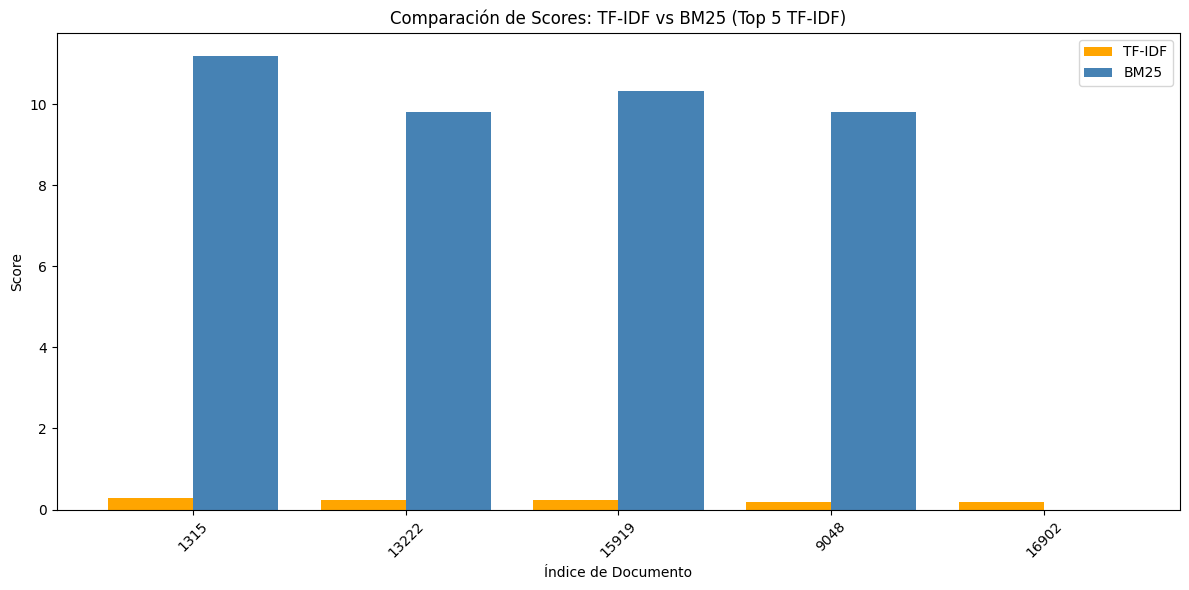

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

# Selecciona los mismos documentos top_n para ambos modelos (por ejemplo, los top 10 de TF-IDF)
top_n = 5
top_tfidf_indices = top_docs_idx[:top_n]


# Gráfico de barras comparativo
tfidf_scores_top = similitudes[top_docs_idx]
bm25_scores_top = bm25_scores[top_docs_idx]
plt.figure(figsize=(12, 6))
plt.bar(range(top_n), tfidf_scores_top, width=0.4, label='TF-IDF', align='center', color='orange')
plt.bar([i + 0.4 for i in range(top_n)], bm25_scores_top, width=0.4, label='BM25', align='center', color='steelblue')
plt.xticks([i + 0.2 for i in range(top_n)], top_docs_idx, rotation=45)
plt.xlabel('Índice de Documento')
plt.ylabel('Score')
plt.title('Comparación de Scores: TF-IDF vs BM25 (Top 5 TF-IDF)')
plt.legend()
plt.tight_layout()
plt.show()

## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?


📊 Evaluación de modelos para la consulta: space shuttle
Documentos relevantes definidos manualmente: {420, 135, 40, 123, 987}
🔹 BM25    - Precision@3: 0.000, MAP: 0.000
🔸 TF-IDF  - Precision@3: 0.000, MAP: 0.000


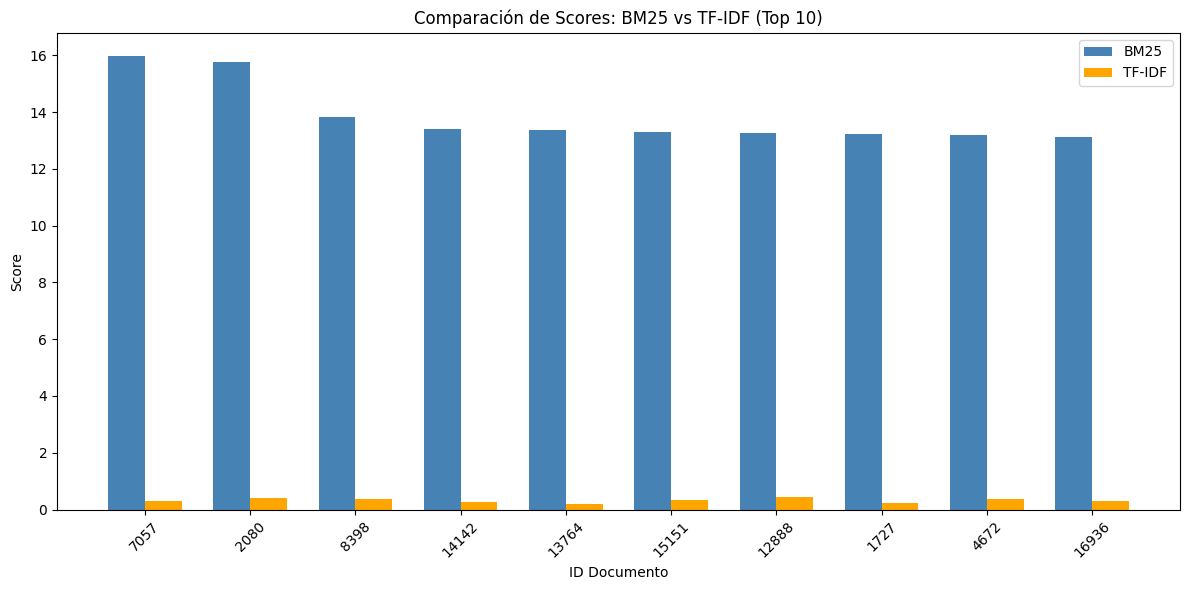


📝 Comparación de documentos top 10 (según BM25):
   Documento  Score BM25  Score TF-IDF Relevante
0       7057   15.989355      0.298103          
1       2080   15.774952      0.393987          
2       8398   13.830863      0.367030          
3      14142   13.402936      0.254314          
4      13764   13.368513      0.206197          
5      15151   13.306665      0.347948          
6      12888   13.246286      0.444718          
7       1727   13.218306      0.217398          
8       4672   13.205103      0.376883          
9      16936   13.127146      0.298001          


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi

# -----------------------------------------------------
# Paso 1: Cargar corpus y definir consulta relevante
# -----------------------------------------------------
# Suponiendo que ya tienes cargado el corpus 'newsgroupsdocs'
# Ejemplo si no lo tienes:
# from sklearn.datasets import fetch_20newsgroups
# newsgroups = fetch_20newsgroups(subset='all')
# newsgroupsdocs = newsgroups.data

# Consulta
consulta = "space shuttle"

# Documentos que consideras relevantes (ajusta según tu conocimiento del corpus)
documentos_relevantes = {40, 123, 135, 420, 987}

# -----------------------------------------------------
# Paso 2: Preprocesamiento para BM25 y TF-IDF
# -----------------------------------------------------
tokenized_corpus = [doc.lower().split() for doc in newsgroupsdocs]

# BM25
bm25 = BM25Okapi(tokenized_corpus)
consulta_bm25 = consulta.lower().split()
bm25_scores = bm25.get_scores(consulta_bm25)
ranking_bm25 = np.argsort(bm25_scores)[::-1]

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(newsgroupsdocs)
consulta_tfidf = tfidf_vectorizer.transform([consulta])
tfidf_scores = cosine_similarity(X_tfidf, consulta_tfidf).flatten()
ranking_tfidf = np.argsort(tfidf_scores)[::-1]

# -----------------------------------------------------
# Paso 3: Funciones de evaluación
# -----------------------------------------------------
def precision_at_k(ranking, relevantes, k):
    ranking_k = ranking[:k]
    aciertos = sum(1 for doc_id in ranking_k if doc_id in relevantes)
    return aciertos / k

def average_precision(ranking, relevantes):
    precisiones = []
    hits = 0
    for i, doc_id in enumerate(ranking):
        if doc_id in relevantes:
            hits += 1
            precisiones.append(hits / (i + 1))
    if hits == 0:
        return 0.0
    return sum(precisiones) / hits

# -----------------------------------------------------
# Paso 4: Cálculo de métricas
# -----------------------------------------------------
precision3_bm25 = precision_at_k(ranking_bm25, documentos_relevantes, 3)
map_bm25 = average_precision(ranking_bm25, documentos_relevantes)

precision3_tfidf = precision_at_k(ranking_tfidf, documentos_relevantes, 3)
map_tfidf = average_precision(ranking_tfidf, documentos_relevantes)

# -----------------------------------------------------
# Paso 5: Resultados y comparación
# -----------------------------------------------------
print("\n📊 Evaluación de modelos para la consulta:", consulta)
print("Documentos relevantes definidos manualmente:", documentos_relevantes)
print(f"🔹 BM25    - Precision@3: {precision3_bm25:.3f}, MAP: {map_bm25:.3f}")
print(f"🔸 TF-IDF  - Precision@3: {precision3_tfidf:.3f}, MAP: {map_tfidf:.3f}")

# -----------------------------------------------------
# Paso 6: Visualización (opcional)
# -----------------------------------------------------
top_n = 10
top_docs = ranking_bm25[:top_n]

comparacion_df = pd.DataFrame({
    'Documento': top_docs,
    'Score BM25': [bm25_scores[i] for i in top_docs],
    'Score TF-IDF': [tfidf_scores[i] for i in top_docs],
    'Relevante': ['✅' if i in documentos_relevantes else '' for i in top_docs]
})

plt.figure(figsize=(12, 6))
x = np.arange(len(comparacion_df))
bar_width = 0.35

plt.bar(x - bar_width/2, comparacion_df['Score BM25'], bar_width, label='BM25', color='steelblue')
plt.bar(x + bar_width/2, comparacion_df['Score TF-IDF'], bar_width, label='TF-IDF', color='orange')

plt.xlabel('ID Documento')
plt.ylabel('Score')
plt.title('Comparación de Scores: BM25 vs TF-IDF (Top 10)')
plt.xticks(x, comparacion_df['Documento'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\n📝 Comparación de documentos top 10 (según BM25):")
print(comparacion_df[['Documento', 'Score BM25', 'Score TF-IDF', 'Relevante']])

